# Q1

In [1]:
import pandas as pd

df = pd.read_csv('q1/click_event_log.csv')
df.head()

,user_id,ad_id,clicked_on_ad
0,20,308,0
1,35,270,0
2,36,168,0
3,21,479,0
4,86,321,0


In [3]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


ohe_user = OneHotEncoder()
ohe_ad = OneHotEncoder()
user_features = ohe_user.fit_transform(df['user_id'].reshape((-1, 1)))
ad_features = ohe_ad.fit_transform(df['ad_id'].reshape((-1, 1)))
X = hstack([user_features, ad_features]).todense()

y = df['clicked_on_ad'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, oob_score=True)
clf.fit(X_train, y_train)
print("OOB score: {}".format(clf.oob_score_))

predictions = clf.predict(X_test)
print(confusion_matrix(y_test, predictions))

OOB score: 0.83175
[[844  10]
 [146   0]]


a. Given a user_id and an ad_id, create a model that will predict the probability that the user will click on the ad. List any assumptions you make about the data when you create this model. What does this model output for user_id 12 and ad_id 10? What about user_id 50 and ad_id 177? Finally, what about user_id 13 and ad_id 241?

In [30]:
import numpy as np

users = np.array([12, 50, 13]).reshape((-1, 1)) - 1
ads = np.array([10, 177, 241]).reshape((-1, 1)) - 1

user_features = ohe_user.transform(users)
ad_features = ohe_ad.transform(ads)
features = hstack([user_features, ad_features]).todense()

clf.predict(features)

array([0, 0, 0], dtype=int64)

# Deprecated

In [4]:
from sklearn import naive_bayes

clf = naive_bayes.BernoulliNB()
clf.fit(X, y)

predictions = clf.predict(X)
confusion_matrix(y, clf.predict(X))

array([[4247,    3],
       [ 742,    8]])

In [6]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X, y)

predictions = clf.predict(X)
print(confusion_matrix(y, predictions))

[[4248    2]
 [ 745    5]]


# Q2

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

df = pd.read_csv('q2/satelite_20.csv')
df.head()

,log_azimuth,log_altitiude,lens_size,months_in_operation,observed_image_output
0,2.351222,2.996789,8.041122,1,0
1,2.379440,3.050773,5.448220,3,0
2,2.441207,3.071607,2.134721,3,0
3,2.454324,3.127072,7.271947,1,0
4,2.465330,3.162127,6.854447,0,0


Counter({0: 51, 1: 51, 2: 51})


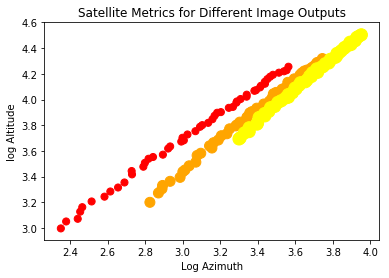

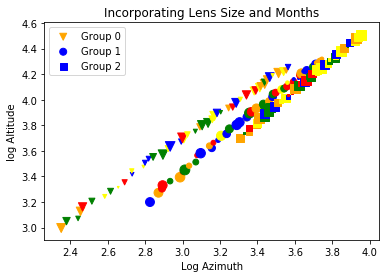

In [2]:
# Exploratory Data Analysis
from collections import Counter

print(Counter(df['observed_image_output']))

color_dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

plt.scatter(df['log_azimuth'], df['log_altitiude'], 
            c=[color_dict[element] for element in df['observed_image_output']],
           s=(df['observed_image_output'] + 1) * 50)
plt.xlabel('Log Azimuth'); plt.ylabel('log Altitude')
plt.title('Satellite Metrics for Different Image Outputs')
plt.show()

for grp in df.groupby('observed_image_output'): # adding lens size and observed_image_output
    df_temp = grp[1]
    plt.scatter(df_temp['log_azimuth'], df_temp['log_altitiude'],
                c=[color_dict[element] for element in df_temp['months_in_operation']],
                s=(df_temp['lens_size']) * 10, 
                marker=['v', 'o', 's'][grp[0]], 
                label='Group {}'.format(grp[0]))
    plt.legend()
    plt.xlabel('Log Azimuth'); plt.ylabel('log Altitude')
    plt.title('Incorporating Lens Size and Months')

### Q2.a

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

rescaler = preprocessing.Normalizer()
X = rescaler.fit_transform(df[['log_azimuth', 'log_altitiude']])
y = df['observed_image_output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


n_neighbors = 5
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(confusion_matrix(y_test, predictions)) 

[[10  0  0]
 [ 0  7  2]
 [ 0  0 12]]


### Q2.b

In [4]:
df_test = pd.read_csv('q2/satelite_20_test.csv')
print(clf.predict(df_test[['log_azimuth', 'log_altitiude']])) # yay! correct predictions

[0 0 0 0 2 2 1 1 2 2 2 2]


### Discussion
Took me many tries. I used XGBoost and Random Forest (with Out-of-Bag-Error) with cross validation and grid search. I wish I had more time so that I would be comfortable working out the Explatory Data Analysis with plots.

From inspection of the plot, I determined that log_azimuth and log_altitiude are the main features. I do not know lens_size and months_in_operation. My only concern is that I performed manual feature selection/importance; but I assume these features are important because the satellite travels in a mechanical way with minimal deviance from its path. In addition, below is a random forest model that shows feature importance that supports my beliefs.

With different train_test_split, I've run the K-Nearest Neighbors (KNN) model multiple times and most predictions for the validation set are correct. The errors are when it cannot determine whether the picture was from group 1 or 2 since the satellite moves in similar trajectories for those. Ideally, I wanted to create a classifier that checks distance from each image_output's satellite trajectory. I settled with KNN because it appears to work well and I'm low on time.

### Deprecated: Random Forest Model with Feature Importance

OOB score: 0.732026143791


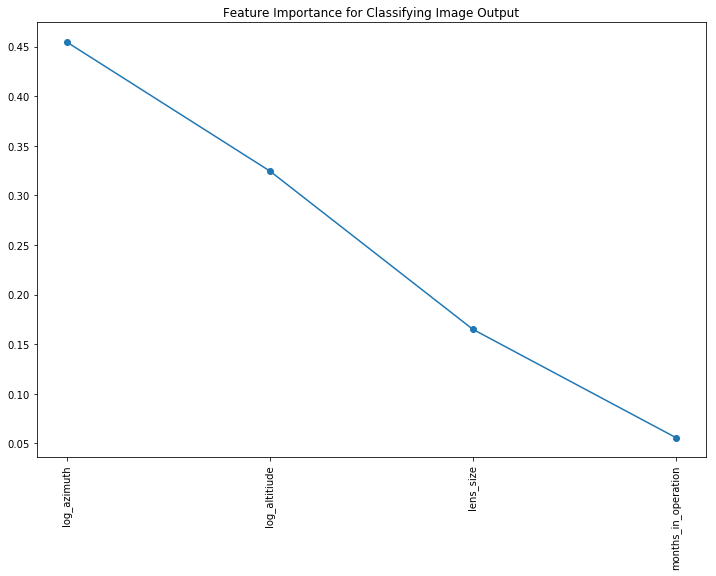

In [5]:
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('q2/satelite_20.csv')

X = df.drop('observed_image_output', axis=1)
y = df['observed_image_output']

clf = RandomForestClassifier(n_estimators=100, oob_score=True)
clf.fit(X, y)
print("OOB score: {}".format(clf.oob_score_))

xlabels = df.columns[:-1]
plt.figure(figsize=(12, 8))
plt.plot(clf.feature_importances_, 'o-')
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.title("Feature Importance for Classifying Image Output")
plt.show()

# Q3

In [1]:
import pandas as pd

df_dams = pd.read_csv('q3/dams.csv')
df_dams.head()

,from_dam,to_dam,amount,week
0,2,7,685,1
1,3,8,423,2
2,6,9,1026,3
3,7,9,817,4
4,3,8,2858,5


### Q3.a 

In [2]:
from collections import defaultdict
import numpy as np

def average(lst):
        return sum(lst) / float(len(lst)) if lst else 0.0

dam_connections = defaultdict(list)
for from_dam, to_dam, amount in df_dams.drop('week', axis=1).values:
    connection_pair = tuple(sorted([from_dam, to_dam]))
    dam_connections[connection_pair].append(amount)
    

flow_matrix = np.zeros((11, 11))
for dam_pair in dam_connections:
    flow_matrix[dam_pair] = average(dam_connections[dam_pair])
    flow_matrix[dam_pair[::-1]] = average(dam_connections[dam_pair])
flow_matrix = flow_matrix[1:, 1:] # readjust for index starting at 0
pd.DataFrame(flow_matrix, index=range(1, 11), columns=range(1, 11))

,1,2,3,4,5,6,7,8,9,10
1,2018.000000,1309.50,2408.00,1250.000000,1822.500000,631.000000,653.000000,1094.666667,1034.0,895.0
2,1309.500000,0.00,753.00,319.000000,1684.000000,2618.000000,709.250000,1186.000000,1092.0,1169.0
3,2408.000000,753.00,1677.50,1704.500000,212.000000,1846.750000,0.000000,1640.500000,2865.0,1892.0
4,1250.000000,319.00,1704.50,0.000000,0.000000,2409.000000,1214.000000,1552.666667,1114.2,1499.5
5,1822.500000,1684.00,212.00,0.000000,532.000000,1155.666667,1106.333333,1496.000000,0.0,2586.5
6,631.000000,2618.00,1846.75,2409.000000,1155.666667,0.000000,2610.000000,1562.500000,1582.5,1685.5
7,653.000000,709.25,0.00,1214.000000,1106.333333,2610.000000,0.000000,1386.500000,1178.0,2451.0
8,1094.666667,1186.00,1640.50,1552.666667,1496.000000,1562.500000,1386.500000,1261.000000,2013.0,2145.0
9,1034.000000,1092.00,2865.00,1114.200000,0.000000,1582.500000,1178.000000,2013.000000,0.0,1138.0
10,895.000000,1169.00,1892.00,1499.500000,2586.500000,1685.500000,2451.000000,2145.000000,1138.0,1927.0


In [3]:
on_or_off = np.bool_(flow_matrix) * 1
pd.DataFrame(on_or_off, index=range(1, 11), columns=range(1, 11))

,1,2,3,4,5,6,7,8,9,10
1,1,1,1,1,1,1,1,1,1,1
2,1,0,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,0,1,1,1
4,1,1,1,0,0,1,1,1,1,1
5,1,1,1,0,1,1,1,1,0,1
6,1,1,1,1,1,0,1,1,1,1
7,1,1,0,1,1,1,0,1,1,1
8,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,0,1,1,1,0,1
10,1,1,1,1,1,1,1,1,1,1


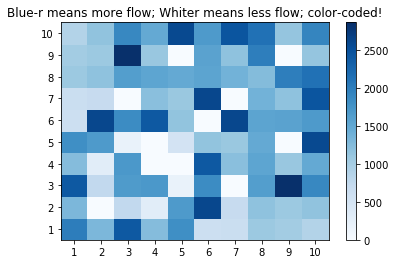

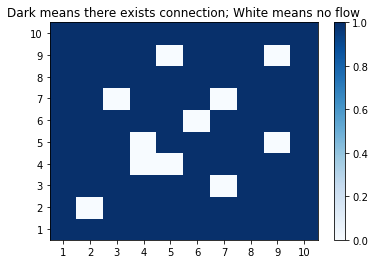

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots()
heatmap = axis.pcolor(flow_matrix, cmap=plt.cm.Blues)
plt.colorbar(heatmap)

axis.set_xticks(np.arange(1, 11) - 0.5)
axis.set_yticks(np.arange(1, 11) - 0.5)
axis.set_xticklabels(range(1, 11))
axis.set_yticklabels(range(1, 11))
plt.title('Blue-r means more flow; Whiter means less flow; color-coded!')
# Modelled on average flow between dams

fig, axis = plt.subplots()
heatmap = axis.pcolor(on_or_off, cmap=plt.cm.Blues)
plt.colorbar(heatmap)

axis.set_xticks(np.arange(1, 11) - 0.5)
axis.set_yticks(np.arange(1, 11) - 0.5)
axis.set_xticklabels(range(1, 11))
axis.set_yticklabels(range(1, 11))
plt.title('Dark means there exists connection; White means no flow');

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


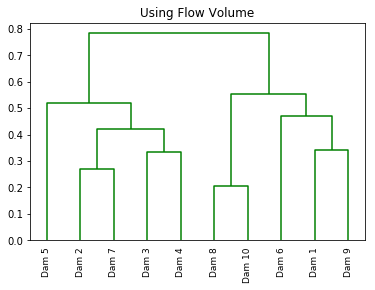

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


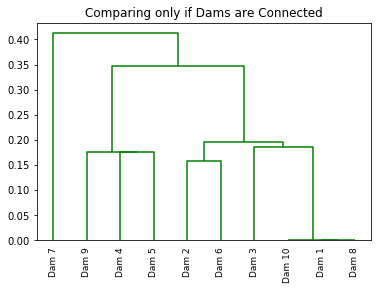

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

distxy = squareform(pdist(flow_matrix, metric='cosine'))
link = linkage(distxy, method='complete') # there are other distance measures
dendro = dendrogram(link, color_threshold=1.5, leaf_font_size=9,
                    labels=['Dam {}'.format(dam) for dam in 
                            sorted(set(df_dams.from_dam))], 
                    leaf_rotation=90)
plt.title('Using Flow Volume')
plt.show()

distxy = squareform(pdist(on_or_off, metric='cosine'))
link = linkage(distxy, method='complete')
dendro = dendrogram(link, color_threshold=1.5, leaf_font_size=9,
                    labels=['Dam {}'.format(dam) for dam in 
                            sorted(set(df_dams.from_dam))], 
                    leaf_rotation=90)
plt.title('Comparing only if Dams are Connected')

### Q3.b

In [6]:
dam_volume = defaultdict(dict)
all_dams = set(df_dams.from_dam)

for dam in all_dams:
    dam_volume[dam][0] = 10000

for from_dam, to_dam, amount, week in df_dams.values:
    if from_dam != to_dam:
        dam_volume[from_dam][week] = dam_volume[from_dam][week - 1] - amount
        dam_volume[to_dam][week] = dam_volume[to_dam][week - 1] + amount
    else:
        dam_volume[from_dam][week] = dam_volume[from_dam][week - 1]
    
    for dam in (all_dams - set([from_dam, to_dam])):
        dam_volume[dam][week] = dam_volume[dam][week - 1]
        
    assert sum(dam_volume[dam][week] for dam in all_dams) == \
        100000, 'problem' # make sure all water is conserved

In [7]:
df_log = pd.read_csv('q3/foremen_log.csv')

def get_cracked_dams(string):
    if string == 'none':
        return None
    else:
        return list(int(number) for number in string.split(', '))

df_log['dams_cracked'] = df_log['dams_cracked'].apply(get_cracked_dams)

pd.DataFrame(dam_volume).head() # ledger of dam volume

,1,2,3,4,5,6,7,8,9,10
0,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,10000,9315,10000,10000,10000,10000,10685,10000,10000,10000
2,10000,9315,9577,10000,10000,10000,10685,10423,10000,10000
3,10000,9315,9577,10000,10000,8974,10685,10423,11026,10000
4,10000,9315,9577,10000,10000,8974,9868,10423,11843,10000


In [8]:
volume_in_cracked_dams = defaultdict(list)
uncracked_dam_volumes = dict()

for week, dams_cracked in df_log.values:
    if dams_cracked:
        for dam in dams_cracked:
            volume_in_cracked_dams[dam].append(dam_volume[dam][week])
        uncracked_dams = all_dams - set(dams_cracked)
        uncracked_dam_volumes[week] = sorted(dam_volume[dam][week] 
                                             for dam in uncracked_dams)[-1]
    elif dams_cracked is None:
        uncracked_dam_volumes[week] = sorted(dam_volume[dam][week]
                                             for dam in all_dams)[-1]
    else:
        "Print unexpected error"

In [9]:
def predict_crack(dam_volume_list, dam_threshold_no_crack, dam_threshold_crack):
    cracked_dams = []
    undetermined_dams = []
    for dam_number, volume in enumerate(dam_volume_list, 1):
        if volume >= dam_threshold_crack:
            cracked_dams.append(dam_number)
        elif volume > dam_threshold_no_crack:
            undetermined_dams.append(dam_number)
    
    if (not cracked_dams and not undetermined_dams):
        return None
    elif not undetermined_dams:
        return cracked_dams
    else:
        return cracked_dams, undetermined_dams

dam_threshold_no_crack = max(uncracked_dam_volumes.values())
dam_threshold_crack = min(reduce(lambda x, y: x + y, volume_in_cracked_dams.values()))
    
dam_predictions = pd.DataFrame(dam_volume).apply(lambda row: 
    predict_crack(row, dam_threshold_no_crack, dam_threshold_crack), axis=1)
print(pd.Series(dam_predictions)[1:31].values == df_log['dams_cracked'].values).all() 
# check if all dam cracking predictions match the ground truth

True


### Discussion
If None, then no dams are broken.  
Else, there can be 1 or 2 lists. The first list is known cracked dams. If the second list exists, it would be dams that are not known whether to be cracked or not since they are below the minimum
cracked dam volume but also above the highest known uncracked dam volume. 

In [10]:
dam_predictions

0                 None
1                 None
2                 None
3                 None
4                 None
5                 None
6                 None
7                 None
8                 None
9                 None
10                None
11                 [9]
12                 [9]
13                 [9]
14                 [9]
15                 [9]
16                 [9]
17                 [9]
18                 [9]
19                 [4]
20              [4, 8]
21           [4, 8, 9]
22           [4, 8, 9]
23           [4, 8, 9]
24           [4, 8, 9]
25              [4, 8]
26              [4, 8]
27              [4, 8]
28                 [8]
29                 [8]
            ...       
66    ([1, 4, 8], [6])
67       ([1, 8], [6])
68       ([1, 8], [6])
69       ([1, 8], [6])
70       ([1, 8], [6])
71       ([1, 8], [6])
72       ([1, 8], [6])
73       ([1, 8], [6])
74              [1, 8]
75              [1, 8]
76              [1, 8]
77              [1, 8]
78       ([